### 1.1 Multi-armed bandits: 3 restaurants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import random
%matplotlib inline

Here we have a setup discussed on [YouTube](https://www.youtube.com/watch?v=e3L4VocZnnQ) about a visiting professor spending 300 days in a new town. The professor wants to optimise their dining enjoyment of three restaurants. R1, R2 and R3. Each resturant will give an 'average' satisfaction for a meal with some distribution. The goal is to maximise the professors enjoyment and minimise their regret.

I'm choosing this as it's similar enough to the 10-armed bandit problem that the epsilon-greedy approaches can be looked at, but it is small enough that all the steps should be easy to follow

In [2]:
def restaurant():
    """Parameters for the three restaurants. Mean and standard deviation"""
    m=[10,8,5] #Mean for each of the 3 restaurants
    s=[5,4,2.5] #Standard deviation for each of the 3 restaurants
    return m, s

In [3]:
def plot_restaurant_dist():
    """Plot the distrubution of satisfaction of the three restaurants"""
    m, s = restaurant()
    colour=['#648FFF','#DC267F','#FFB000']
    linestyle=['solid','dotted','dashdot']
    for _ in range(len(m)):
        x=np.linspace(m[_] - 3*s[_], m[_] + 3*s[_], 100)
        plt.plot(x, stats.norm.pdf(x, m[_], s[_]),
                 color=colour[_],label="Restaurant#"+str(_+1),
                linestyle=linestyle[_])
    
    plt.xlabel("Satisfaction")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()

Here we have the distributions of satisfactions for each restaurant. Restaurant 1 has an average satisfaction of 10, with a standard deviation of 5. Restaurant 2 has an average satisfaction of 8, with a standard deviation of 4. Restaurant 3 has an average satisfaction of 5, with a standard deviation of 2.5.

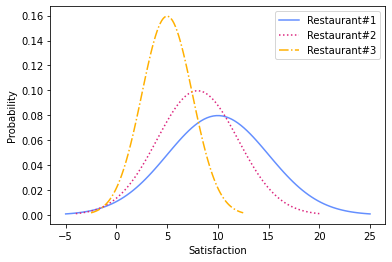

In [4]:
plot_restaurant_dist()

#### 1.1.1 Defining the best restaurant
Here I want to point out that I'm defining the best restaurant as the one with the highest average, which in this case is restaurant'#'1. When I'm analysing if the optimal choice is made, here I am looking at if Restauran'#'1 was picked.

#### 1.1.2 Caveats
I want to point out another caveat here. This is a stationary problem. We are assuming that the distributions of the satisfaction for each restaurant remain static (stationary) over time, and therefore information on the satisfaction we got on day 1 is just as relevant as information we got yesterday.

If the problem is non-stationary then we need to weight more recent data higher than older data.

#### 1.1.3 Averages or sums?
The satisfaction can be calculated in a number of ways, we can simply sum the satisfaction from each or we can keep track of the number of visits and get an average by dividing the sum by n, or we can work out the averages incrementally using the following equation:

Qn+1 = Qn + 1/n(Rn-Qn)

Where the new average of all rewards, Qn+1, is calcualted by the nth average, Qn, and the nth reward, Rn

In [5]:
def inc_av(n,R,Q):
    """Equation 2.3 in sutton and Barto"""
    newQ = Q + ((1/n)*(R-Q))
    return(newQ)

### 1.2 Purely Explorative

In this example the professor will split their time equally between the three restaurants. So if they are visiting for 100 days, they will visit each restaurant 100 times.
I'm adding a bit of noise here, picking 300 random numbers between 1 and 3 (inclusive) but that will still on average give 100 visits per restaurant if we run the experiment enough times.

In [6]:
def explorative(nvis):
    """A purely explorative method. Where each resturant is just as likely as the other to be visited
    regardless of the overall satisfaction that has been calculated."""
    inc=np.zeros(3)
    q=np.zeros(3)
    m, s = restaurant()
    for _ in range(nvis):
        pick = random.randint(0,2)
        inc[pick] += 1
        r=np.random.normal(m[pick],s[pick])
        q[pick] = inc_av(inc[pick],r,q[pick])
    return(q, inc)

In [7]:
def exp_explore(nexp):
    """Run the experiment several times"""
    opt_total = 0
    nvis=300
    sub_opt_total = 0
    for _ in range(nexp):
        av, eachvis = explorative(nvis)
        opt_total += eachvis[0]
        sub_opt_total += eachvis[1]
        sub_opt_total += eachvis[2]
    percent=(opt_total/(nexp*nvis))*100
    percent_subopt=100*(sub_opt_total/(nvis*nexp))
    print(f'Out of {nexp} experiments, each taking {nvis} days;')
    print(f'The optimal restaurant was correctly identified {round(percent,1)}% of the time, based on the calculated mean')
    print(f'The professor however, also spent {round(percent_subopt,1)}% of their time at sub-optimal restaurants')
    return(percent)

In [8]:
explore_percent = exp_explore(1000)

Out of 1000 experiments, each taking 300 days;
The optimal restaurant was correctly identified 33.4% of the time, based on the calculated mean
The professor however, also spent 66.6% of their time at sub-optimal restaurants


Perhaps unsuprisingly when a restaurant is sampled 100 times a realistic description of the (Gaussian) distribution can be found, this isn't unexpected, but in this method around 2/3 of the time the professor was visiting a sub-optimal restaurant.

Can we improve upon this?
What about if we only ever go to the 'best' restaurant?

### 1.3 Purely Exploitative
In this example, we start with our estimation of the satisfaction from each restaurant as 0, then the professor picks one at random. If the professor has a positive visit there (that is a postive satisfaction) then the professor will exclusively visit there to eat, if the visit results in a negative satisfaction then another restaurant will be picked. We would also need to deal with 'tie breakers'

In [9]:
def tiebreak(array, dupe):
    """Tiebreaker"""
    broken=False
    while broken is False:
        pick = random.randint(0,len(array)-1)
        broken = array[pick] == dupe
    return pick

In [10]:
def exploit(nvis):
    """A purely exploitative method. Where the restaurant with the highest satisfaction is consistently picked"""
    m, s = restaurant()
    inc=np.zeros(3)
    q=np.zeros(3)
    for _ in range(nvis):
        if list(q).count(np.max(q)) > 1:
            pick = tiebreak(q,np.max(q))
            inc[pick] += 1
            r=np.random.normal(m[pick],s[pick])
            q[pick] = inc_av(inc[pick],r,q[pick])
        else:
            pick = np.argmax(q)
            inc[pick] += 1
            r=np.random.normal(m[pick],s[pick])
            q[pick] = inc_av(inc[pick],r,q[pick])
    return(q, inc)

In [11]:
def exp_exploit(nexp):
    """Run the experiment several times"""
    opt_total = 0
    nvis=300
    sub_opt_total = 0
    for _ in range(nexp):
        av, eachvis = exploit(nvis)
        opt_total += eachvis[0]
        sub_opt_total += eachvis[1]
        sub_opt_total += eachvis[2]
    percent=(opt_total/(nexp*nvis))*100
    percent_subopt=100*(sub_opt_total/(nvis*nexp))
    print(f'Using this greedy method, where we only visit the apparent best restuaruant, out of {nexp} trials')
    print(f'The optimal restaurant was visited {round(percent,1)}% of the time')
    print(f'The professor however, spent {round(percent_subopt,1)}% of their time at sub-optimal restaurants')
    return percent

In [12]:
exploit_percent = exp_exploit(1000)

Using this greedy method, where we only visit the apparent best restuaruant, out of 1000 trials
The optimal restaurant was visited 33.9% of the time
The professor however, spent 66.1% of their time at sub-optimal restaurants


### 1.3.1 What about if we start with a non-zero average value?
Here we see that we only spend around a third of our time at the optimal restaurant, and this does seem to make sense. When we know nothing about the distributions and just pick one at random, as long as we don't have a negative satisfaction there then we will keep going to it, as the other two restuarants will have a satisfaction of 0 still (because they haven't been updated/visited) But what about if we start with an assumption that each restaurant will give us a satisfaction of 5, then we apply the greedy method?exploit_offset_start(nvis)

In [13]:
def exploit_offset(nvis, offset):
    """A purely exploitative method. Where the restaurant with the highest satisfaction is consistently picked
    This time however we assume that all have an initial satisfaction (q) of whatever the offset is"""
    m, s = restaurant()
    inc=np.zeros(3)
    q=np.ones(3)*offset
    for _ in range(nvis):
        if list(q).count(np.max(q)) > 1:
            pick = tiebreak(q,np.max(q))
            inc[pick] += 1
            r=np.random.normal(m[pick],s[pick])
            q[pick] = inc_av(inc[pick],r,q[pick])
        else:
            pick = np.argmax(q)
            inc[pick] += 1
            r=np.random.normal(m[pick],s[pick])
            q[pick] = inc_av(inc[pick],r,q[pick])
    return(q, inc)

In [14]:
def exp_exploit_offset(nexp,offset):
    """Run the experiment several times"""
    opt_total = 0
    nvis=300
    sub_opt_total = 0
    for _ in range(nexp):
        av, eachvis = exploit_offset(nvis,offset)
        opt_total += eachvis[0]
        sub_opt_total += eachvis[1]
        sub_opt_total += eachvis[2]
    percent=(opt_total/(nexp*nvis))*100
    percent_subopt=100*(sub_opt_total/(nvis*nexp))
    print(f'Using this greedy method, where we only visit the apparent best restuaruant, out of {nexp} trials')
    print(f'The optimal restaurant was visited {round(percent,1)}% of the time')
    print(f'The professor however, spent {round(percent_subopt,1)}% of their time at sub-optimal restaurants')
    return percent

In [15]:
exploit_offset_2 = exp_exploit_offset(1000,2)
exploit_offset_5 = exp_exploit_offset(1000,5)
exploit_offset_10 = exp_exploit_offset(1000,10)
exploit_offset_50 = exp_exploit_offset(1000,50)

Using this greedy method, where we only visit the apparent best restuaruant, out of 1000 trials
The optimal restaurant was visited 32.4% of the time
The professor however, spent 67.6% of their time at sub-optimal restaurants
Using this greedy method, where we only visit the apparent best restuaruant, out of 1000 trials
The optimal restaurant was visited 54.0% of the time
The professor however, spent 46.0% of their time at sub-optimal restaurants
Using this greedy method, where we only visit the apparent best restuaruant, out of 1000 trials
The optimal restaurant was visited 68.1% of the time
The professor however, spent 31.9% of their time at sub-optimal restaurants
Using this greedy method, where we only visit the apparent best restuaruant, out of 1000 trials
The optimal restaurant was visited 70.3% of the time
The professor however, spent 29.7% of their time at sub-optimal restaurants


### 1.4 Epsilon Greedy
In the epsilon greedy example, we try to balance the desire to explore (to get to know the distributions of the three restaurants sufficiently well) with the desire to exploit (to go to the restaurant that will give us the greatest satisfaction). The process here, is to pick a value of epsilon (say 10%) and for that percentage of the time of the professor's visit, they will pick a restaurant at random. For the other 90% of the time in this case, they will visit the restaurant that they have calculated will give them the greatest satisfaction. Now this calculation may change after more visits to the three restaurants give a more realistic idea of their satisfaction. As with the exploitative method, we do need to pick a restaurant at random to start with.

In [16]:
def epsilon_greedy(nvis, epsilon):
    """A mix of exploitative and exploratory methods. 
   There is a probability that even when some informaiton about the distribution of the satisfactions is known
   that the algorithm will pick a random restaurant, not just the best one"""
    m, s = restaurant()
    inc=np.zeros(3)
    q=np.zeros(3)
    for _ in range(nvis):
        chkeps=np.random.uniform()
        if(chkeps < epsilon):
            # If the random number is greater than epsilon then pick a random restaurant
            pick = random.randint(0,2)
            inc[pick] += 1
            r=np.random.normal(m[pick],s[pick])
            q[pick] = inc_av(inc[pick],r,q[pick])
        elif list(q).count(np.max(q)) > 1:
            # Deal with tiebreak
            pick = tiebreak(q,np.max(q))
            inc[pick] += 1
            r=np.random.normal(m[pick],s[pick])
            q[pick] = inc_av(inc[pick],r,q[pick])
        else:
            # Pick the best restaurant
            pick = np.argmax(q)
            inc[pick] += 1
            r=np.random.normal(m[pick],s[pick])
            q[pick] = inc_av(inc[pick],r,q[pick])
    return(q, inc)

In [17]:
def exp_eps_greedy(nexp,epsilon):
    """Run the experiment several times"""
    nvis=300
    sub_opt_total = 0
    opt_total = 0
    for _ in range(nexp):
        av, eachvis = epsilon_greedy(nvis,epsilon)
        opt_total += eachvis[0]
        sub_opt_total += eachvis[1]
        sub_opt_total += eachvis[2]
    percent=(opt_total/(nexp*nvis))*100
    percent_subopt=100*(sub_opt_total/(nvis*nexp))
    print(f'Using this epsilon greedy method, with epsilon = {epsilon}, and out of {nexp} trials')
    print(f'The optimal restaurant was visited {round(percent,1)}% of the time')
    print(f'The professor however, spent {round(percent_subopt,1)}% of their time at sub-optimal restaurants')
    return percent

In [18]:
eps_greedy_001 = exp_eps_greedy(1000,0.01)
eps_greedy_01 = exp_eps_greedy(1000,0.1)
eps_greedy_03 = exp_eps_greedy(1000,0.3)
eps_greedy_05 = exp_eps_greedy(1000,0.5)

Using this epsilon greedy method, with epsilon = 0.01, and out of 1000 trials
The optimal restaurant was visited 47.0% of the time
The professor however, spent 53.0% of their time at sub-optimal restaurants
Using this epsilon greedy method, with epsilon = 0.1, and out of 1000 trials
The optimal restaurant was visited 77.5% of the time
The professor however, spent 22.5% of their time at sub-optimal restaurants
Using this epsilon greedy method, with epsilon = 0.3, and out of 1000 trials
The optimal restaurant was visited 73.5% of the time
The professor however, spent 26.5% of their time at sub-optimal restaurants
Using this epsilon greedy method, with epsilon = 0.5, and out of 1000 trials
The optimal restaurant was visited 63.8% of the time
The professor however, spent 36.2% of their time at sub-optimal restaurants


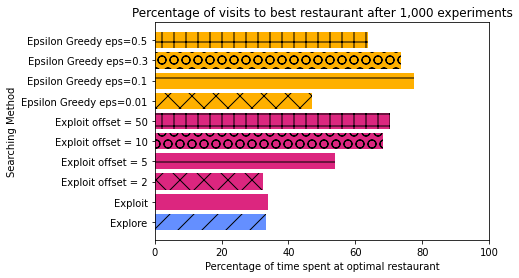

In [19]:
x = [
    'Explore', 
    'Exploit', 
    'Exploit offset = 2', 
    'Exploit offset = 5', 
    'Exploit offset = 10', 
    'Exploit offset = 50', 
    'Epsilon Greedy eps=0.01', 
    'Epsilon Greedy eps=0.1', 
    'Epsilon Greedy eps=0.3',
    'Epsilon Greedy eps=0.5'
    ]
results = [
    explore_percent,
    exploit_percent,
    exploit_offset_2,
    exploit_offset_5,
    exploit_offset_10,
    exploit_offset_50,
    eps_greedy_001,
    eps_greedy_01,
    eps_greedy_03,
    eps_greedy_05
        ]
colour=['#648FFF','#DC267F','#DC267F','#DC267F','#DC267F','#DC267F','#FFB000','#FFB000','#FFB000','#FFB000']
hatch = ['/','','x','-','O','+','x','-','O','+']

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, results, color=colour,hatch=hatch,linestyle='-')
plt.ylabel("Searching Method")
plt.xlabel("Percentage of time spent at optimal restaurant")
plt.title("Percentage of visits to best restaurant after 1,000 experiments")

plt.yticks(x_pos, x)
plt.xlim([0,100])

plt.show()